# Project summary and data exploration. 

Will also be used to create the project summary report.

In [4]:
import os
if not os.path.exists("README.md"):
    os.chdir("../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
degenes = pd.read_csv('./data/final/degenes.csv', index_col=0)
pdata = pd.read_csv('./data/final/pdata_filled.csv', index_col=0)

degenes_t = degenes.T
degenes_t.columns = [x.split('///')[0] for x in degenes_t.columns]
degenes = degenes_t.T
degenes = degenes/10
degenes_t = degenes.T/10

degenes_t.head(3)

In [6]:
pdata.head(3)

,age,biomarker_score,cancer_status,gender,>3cm,packyears,hemopytsis,lymphadenopathy,smoking_status,subjective_assessment
GSM93997,34.0,-2.253540,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0
GSM94019,63.0,8.900589,1.0,1.0,1.0,75.0,0.0,1.0,0.0,1.0
GSM94020,61.0,9.954619,1.0,1.0,1.0,80.0,0.0,1.0,0.0,1.0


In [7]:
pdata_todrop = ['cancer_status', 'subjective_assessment', '>3cm']

<Axes: >

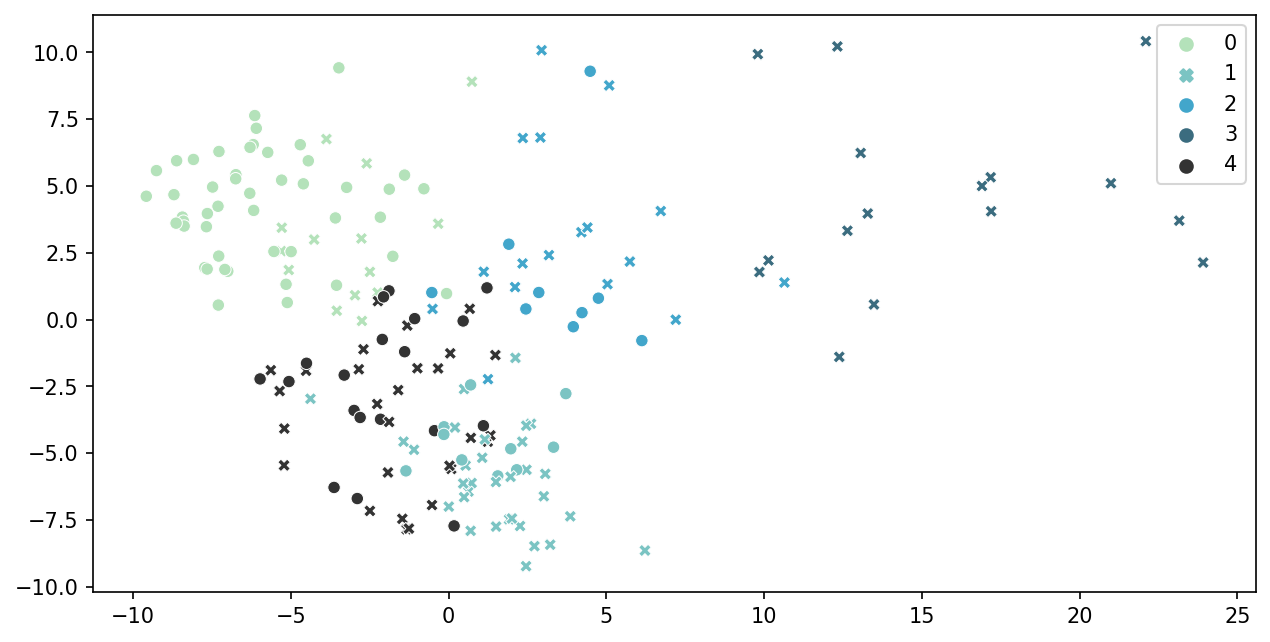

In [8]:
# a little bit of cluster analysis with KMeans
# and some visualization with PCA

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
degenes_scaled = scaler.fit_transform(degenes_t)

kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(degenes_scaled)

pca = PCA(n_components=2)
pca_degenes = pca.fit_transform(degenes_scaled)


fig, ax = plt.subplots(figsize=(10,5), dpi=150)
sns.scatterplot(x=pca_degenes[:,0], y=pca_degenes[:,1], hue=kmeans.labels_, ax=ax, style=pdata['cancer_status'].values, palette='GnBu_d')

/var/folders/h3/td18b9zd6nx0r50mw9g7nr8w0000gn/T/ipykernel_55203/343689735.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=pdata, x='cancer_status', hue='Cluster', palette='GnBu_d', ax=axs[0], fill=True, alpha=0.2)


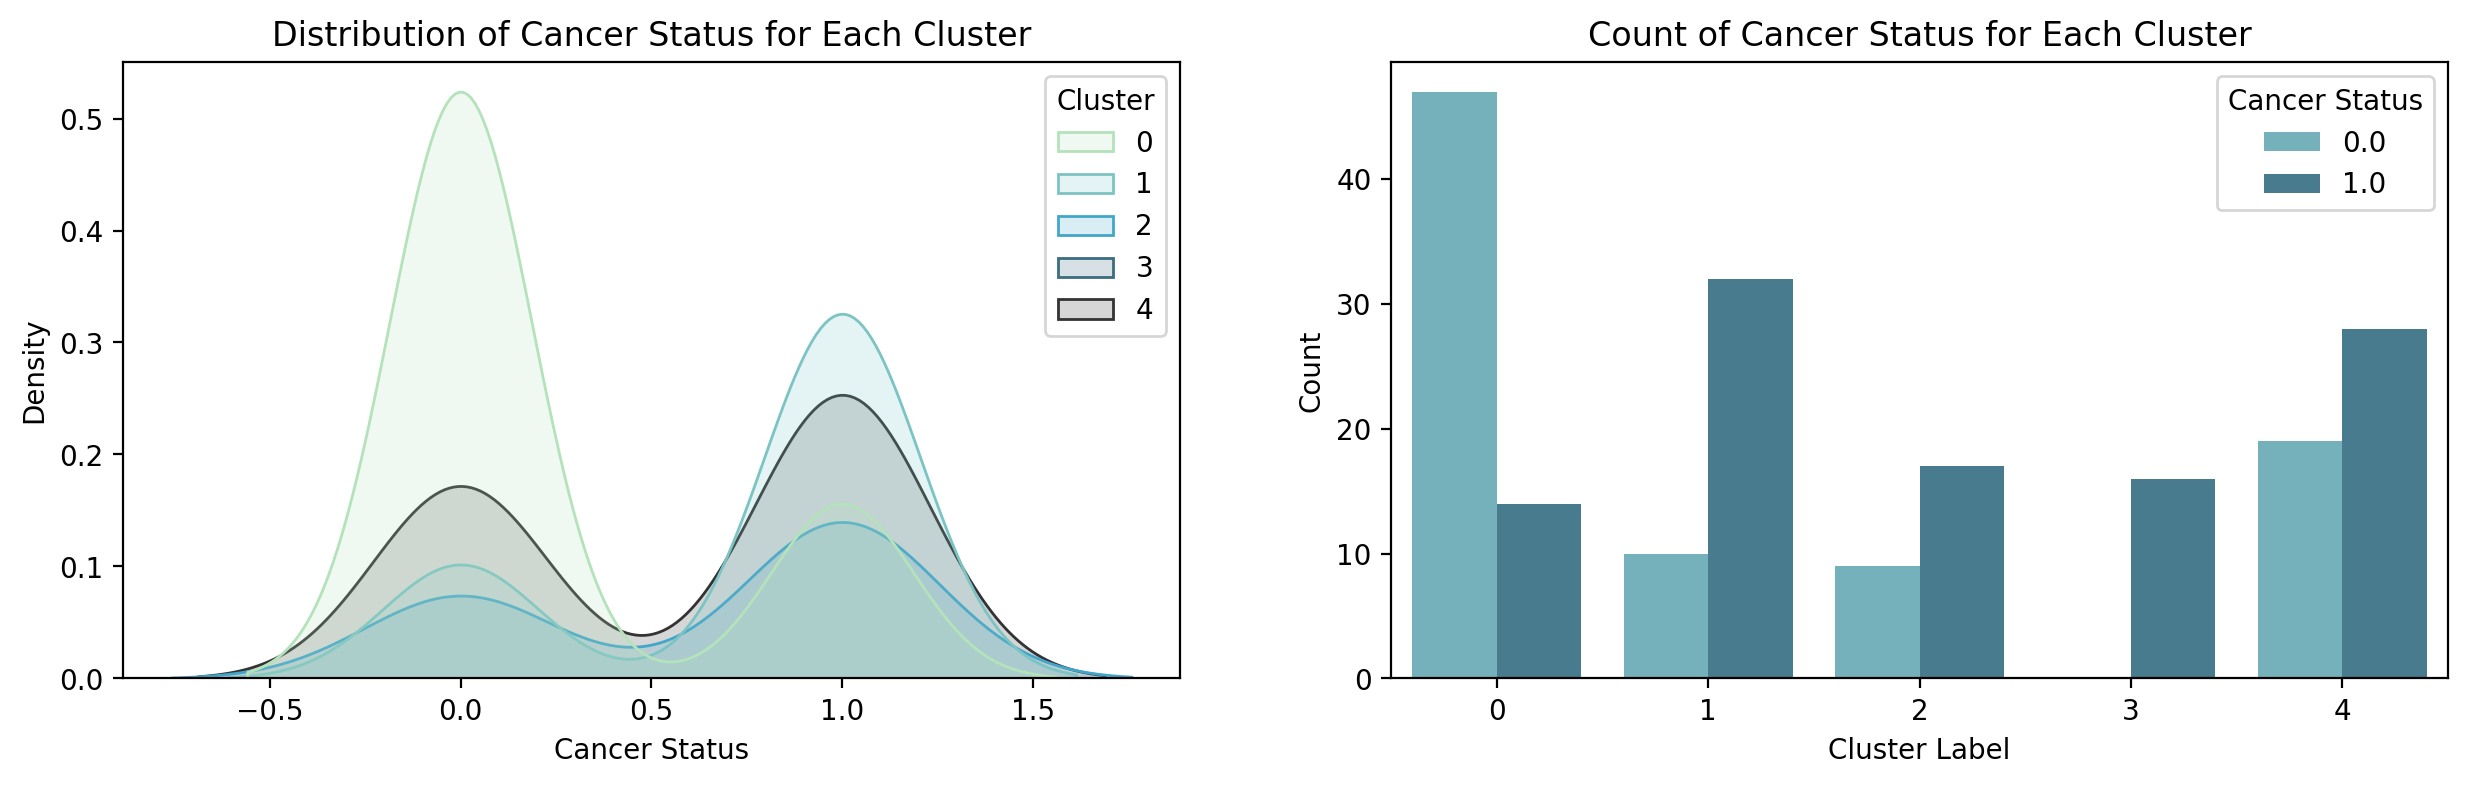

In [9]:
# kdeplot of cancer status for each cluster, hue is cluster label.
# add km labels to pdata
pdata['Cluster'] = kmeans.labels_

fig, axs = plt.subplots(figsize=(15, 4), dpi=200, ncols=2, nrows=1)
sns.kdeplot(data=pdata, x='cancer_status', hue='Cluster', palette='GnBu_d', ax=axs[0], fill=True, alpha=0.2)
axs[0].set_title('Distribution of Cancer Status for Each Cluster')
axs[0].set_xlabel('Cancer Status')
axs[0].set_ylabel('Density')



sns.countplot(data=pdata, x='Cluster', hue='cancer_status', palette='GnBu_d', ax=axs[1])
axs[1].set_title('Count of Cancer Status for Each Cluster')
axs[1].set_xlabel('Cluster Label')
axs[1].set_ylabel('Count')
axs[1].legend(title='Cancer Status')


pdata = pdata.drop(['Cluster'], axis=1)

## Standard classifiers, SVM, MLP, K-NN

### KNN

In [10]:
# knn with only degenes data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X = degenes_t.values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

# kfold cv grid search
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, make_scorer

knn = KNeighborsClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
scorer = make_scorer(accuracy_score)
# f1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# make grid search with both scorers
grid = GridSearchCV(knn, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
knn_degenes_accuracy = accuracy_score(y_test, y_pred)
knn_degenes_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {knn_degenes_accuracy}')
print(f'F1 Score: {knn_degenes_f1}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Accuracy: 0.6153846153846154
F1 Score: 0.6107226107226107


In [11]:
# knn with only pdata
X = pdata.drop(pdata_todrop, axis=1).values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

knn = KNeighborsClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
scorer = make_scorer(accuracy_score)
#f1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# make grid search with both scorers
grid = GridSearchCV(knn, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
knn_pdata_accuracy = accuracy_score(y_test, y_pred)
knn_pdata_f1 = f1_score(y_test, y_pred, average='weighted')


print(f'Best params: {grid.best_params_}')
print(f'Best score: {knn_pdata_accuracy}')
print(f'Best f1 score: {knn_pdata_f1}')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'n_neighbors': 13}
Best score: 0.7435897435897436
Best f1 score: 0.73871237458194


In [12]:
# knn with both
X = np.concatenate((degenes_t.values, pdata.drop(pdata_todrop, axis=1).values), axis=1)
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

knn = KNeighborsClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')
# make grid search with both scorers

grid = GridSearchCV(knn, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)


knn_both_accuracy = accuracy_score(y_test, y_pred)
knn_both_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {knn_both_accuracy}')
print(f'Best F1 score: {knn_both_f1}')


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params: {'n_neighbors': 15}
Best Accuracy: 0.6666666666666666
Best F1 score: 0.6575154426904598


In [13]:
# create a dataframe to compare results
results = pd.DataFrame({'Model': ['KNN', 'KNN', 'KNN'],
                        'Data': ['DEGenes', 'PData', 'Both'],
                        'Accuracy': [knn_degenes_accuracy, knn_pdata_accuracy, knn_both_accuracy],
                        'F1 Score': [knn_degenes_f1, knn_pdata_f1, knn_both_f1]})
results

,Model,Data,Accuracy,F1 Score
0,KNN,DEGenes,0.615385,0.610723
1,KNN,PData,0.743590,0.738712
2,KNN,Both,0.666667,0.657515


### SVM

In [14]:
# here svm with only gene expression
from sklearn.svm import SVC

X = degenes_t.values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

svm = SVC()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']}

scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

grid = GridSearchCV(svm, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1) 
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)

svm_degenes_accuracy = accuracy_score(y_test, y_pred)
svm_degenes_f1 = f1_score(y_test, y_pred, average='weighted')


print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {svm_degenes_accuracy}')
print(f'Best F1 score: {svm_degenes_f1}')


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Accuracy: 0.6410256410256411
Best F1 score: 0.6386260798025504


In [15]:
# here svm with only pdata
X = pdata.drop(pdata_todrop, axis=1).values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)

svm = SVC()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']}

scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')  

grid = GridSearchCV(svm, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)

svm_pdata_accuracy = accuracy_score(y_test, y_pred)
svm_pdata_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {svm_pdata_accuracy}')
print(f'Best F1 score: {svm_pdata_f1}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best Accuracy: 0.7948717948717948
Best F1 score: 0.7909698996655519


In [16]:
# here svm with both
X = np.concatenate((degenes_t.values, pdata.drop(pdata_todrop, axis=1).values), axis=1)
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm = SVC()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'C': [0.1, 1, 10, 100, 1000],
            'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'kernel': ['rbf']}

scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')   

grid = GridSearchCV(svm, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

svm_both_accuracy = grid.cv_results_['mean_test_accuracy'][grid.best_index_]
svm_both_f1 = grid.cv_results_['mean_test_f1'][grid.best_index_]

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {svm_both_accuracy}')
print(f'Best F1 score: {svm_both_f1}')

# create a dataframe to compare results
results_svm = pd.DataFrame({'Model': ['SVM', 'SVM', 'SVM'],
                        'Data': ['DEGenes', 'PData', 'Both'],
                        'Accuracy': [svm_degenes_accuracy, svm_pdata_accuracy, svm_both_accuracy],
                        'F1 Score': [svm_degenes_f1, svm_pdata_f1, svm_both_f1]})

# concatenate results
results = pd.concat([results, results_svm], axis=0)
results = results.sort_values(by='F1 Score', ascending=False)
results

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best params: {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
Best Accuracy: 0.7972043010752687
Best F1 score: 0.7948472812729455


,Model,Data,Accuracy,F1 Score
2,SVM,Both,0.797204,0.794847
1,SVM,PData,0.794872,0.790970
1,KNN,PData,0.743590,0.738712
2,KNN,Both,0.666667,0.657515
0,SVM,DEGenes,0.641026,0.638626
0,KNN,DEGenes,0.615385,0.610723


## Random Forest

In [17]:
# here random forest with only gene expression
from sklearn.ensemble import RandomForestClassifier
# random search
from sklearn.model_selection import RandomizedSearchCV

X = degenes_t.values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features': ['sqrt'],
            'bootstrap': [True, False]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

grid = RandomizedSearchCV(rf, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1, n_iter=32)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
rf_degenes_accuracy = accuracy_score(y_test, y_pred)
rf_degenes_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {rf_degenes_accuracy}')
print(f'Best F1 score: {rf_degenes_f1}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}
Best Accuracy: 0.7948717948717948
Best F1 score: 0.7948717948717948


In [18]:
# here random forest with only pdata
X = pdata.drop(pdata_todrop, axis=1).values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=4)


rf = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features': ['sqrt'],
            'bootstrap': [True, False]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

grid = RandomizedSearchCV(rf, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1, n_iter=32)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
rf_pdata_accuracy = accuracy_score(y_test, y_pred)
rf_pdata_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {rf_pdata_accuracy}')
print(f'Best F1 score: {rf_pdata_f1}')


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'n_estimators': 300, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': True}
Best Accuracy: 0.8205128205128205
Best F1 score: 0.820035778175313


In [19]:
# here random forest with both
X = np.concatenate((degenes_t.values, pdata.drop(pdata_todrop, axis=1).values), axis=1)
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'n_estimators': [100, 200, 300, 400, 500],
            'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features': ['sqrt'],
            'bootstrap': [True, False]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')


grid = RandomizedSearchCV(rf, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1, n_iter=32)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)

rf_both_accuracy = grid.cv_results_['mean_test_accuracy'][grid.best_index_]
rf_both_f1 = grid.cv_results_['mean_test_f1'][grid.best_index_]

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {rf_both_accuracy}')
print(f'Best F1 score: {rf_both_f1}')

# create a dataframe to compare results
results_rf = pd.DataFrame({'Model': ['Random Forest', 'Random Forest', 'Random Forest'],
                        'Data': ['DEGenes', 'PData', 'Both'],
                        'Accuracy': [rf_degenes_accuracy, rf_pdata_accuracy, rf_both_accuracy],
                        'F1 Score': [rf_degenes_f1, rf_pdata_f1, rf_both_f1]})
# concatenate results
results = pd.concat([results, results_rf], axis=0)
results = results.sort_values(by='F1 Score', ascending=False)
results

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best params: {'n_estimators': 200, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
Best Accuracy: 0.7643010752688172
Best F1 score: 0.7596559128363023


,Model,Data,Accuracy,F1 Score
1,Random Forest,PData,0.820513,0.820036
0,Random Forest,DEGenes,0.794872,0.794872
2,SVM,Both,0.797204,0.794847
1,SVM,PData,0.794872,0.790970
2,Random Forest,Both,0.764301,0.759656
1,KNN,PData,0.743590,0.738712
2,KNN,Both,0.666667,0.657515
0,SVM,DEGenes,0.641026,0.638626
0,KNN,DEGenes,0.615385,0.610723


### MLP
(the model with both DE and pdata will be taken from mlp_selection.ipynb)

In [20]:
# here mlp with only gene expression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold

X = degenes_t.values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43)

mlp = MLPClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=43)

params = {'hidden_layer_sizes': [(32,), (64,), (64, 32), (32, 32), (64,64)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive'], 'max_iter':[1000]}

scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

grid = RandomizedSearchCV(mlp, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='f1', cv=kfold, verbose=1, n_jobs=-1, n_iter=64)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
mlp_degenes_accuracy = accuracy_score(y_test, y_pred)
mlp_degenes_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {mlp_degenes_accuracy}')
print(f'Best F1 score: {mlp_degenes_f1}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'solver': 'adam', 'max_iter': 1000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (32, 32), 'alpha': 0.01, 'activation': 'tanh'}
Best Accuracy: 0.7692307692307693
Best F1 score: 0.7710707896754408


In [30]:
# here mlp with only pdata
from sklearn.metrics import accuracy_score, make_scorer, f1_score

X = pdata.drop(pdata_todrop, axis=1).values
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=41)

mlp = MLPClassifier()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'hidden_layer_sizes': [(32,), (64,), (64, 32), (32, 32), (64,64)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam'],
            'alpha': [0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive'], 'max_iter':[3000]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score)

# add both scorers to grid search
grid = GridSearchCV(mlp, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='accuracy', cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)
mlp_pdata_accuracy = accuracy_score(y_test, y_pred)
mlp_pdata_f1 = f1_score(y_test, y_pred, average='weighted')


print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {mlp_pdata_accuracy}')
print(f'Best F1 score: {mlp_pdata_f1}')

Best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
Best Accuracy: 0.7435897435897436
Best F1 score: 0.75


In [34]:
# here mlp with both 
X = np.concatenate((degenes_t.values, pdata.drop(pdata_todrop, axis=1).values), axis=1)
y = pdata['cancer_status'].values

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_scaled)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=41)


mlp = MLPClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

params = {'hidden_layer_sizes': [(32,), (64,),(32, 32)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam'],
            'alpha': [0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'adaptive'], 'max_iter':[3000]}
scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='weighted')

# add both scorers to grid search
grid = GridSearchCV(mlp, params, scoring={'accuracy': scorer, 'f1': f1_scorer}, refit='accuracy', cv=kfold, n_jobs=-1)
grid.fit(X_train, y_train)

# test on test set
y_pred = grid.predict(X_test)

mlp_both_accuracy = accuracy_score(y_test, y_pred)
mlp_both_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Best params: {grid.best_params_}')
print(f'Best Accuracy: {mlp_both_accuracy}')
print(f'Best F1 score: {mlp_both_f1}')

Best params: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
Best Accuracy: 0.9230769230769231
Best F1 score: 0.9222641509433961


In [23]:
# create a dataframe to compare results
results_mlp = pd.DataFrame({'Model': ['MLP', 'MLP', 'MLP'],
                        'Data': ['DEGenes', 'PData', 'Both'],
                        'Accuracy': [mlp_degenes_accuracy, mlp_pdata_accuracy, mlp_both_accuracy],
                        'F1 Score': [mlp_degenes_f1, mlp_pdata_f1, mlp_both_f1]})
# concatenate results
results = pd.concat([results, results_mlp], axis=0)
results = results.sort_values(by='F1 Score', ascending=False)
results

,Model,Data,Accuracy,F1 Score
1,MLP,PData,0.897436,0.897436
2,MLP,Both,0.846154,0.846154
1,Random Forest,PData,0.820513,0.820036
0,Random Forest,DEGenes,0.794872,0.794872
2,SVM,Both,0.797204,0.794847
1,SVM,PData,0.794872,0.790970
0,MLP,DEGenes,0.769231,0.771071
2,Random Forest,Both,0.764301,0.759656
1,KNN,PData,0.743590,0.738712
2,KNN,Both,0.666667,0.657515


In [24]:
# remove gnn from results
results = results[results['Model'] != 'GNN']
results

,Model,Data,Accuracy,F1 Score
1,MLP,PData,0.897436,0.897436
2,MLP,Both,0.846154,0.846154
1,Random Forest,PData,0.820513,0.820036
0,Random Forest,DEGenes,0.794872,0.794872
2,SVM,Both,0.797204,0.794847
1,SVM,PData,0.794872,0.790970
0,MLP,DEGenes,0.769231,0.771071
2,Random Forest,Both,0.764301,0.759656
1,KNN,PData,0.743590,0.738712
2,KNN,Both,0.666667,0.657515


In [25]:
# add entry to results with Model: GNN, Data: Both, Accuracy: 0.87, F1 Score: 0.87
gnn_df = pd.DataFrame({'Model': ['GNN'], 'Data': ['PData'], 'Accuracy': [0.86], 'F1 Score': [0.86]})
results = pd.concat([results, gnn_df], axis=0)
results = results.sort_values(by='F1 Score', ascending=False)

In [ ]:
# make a comparison plot
fig, ax = plt.subplots(figsize=(20,10), dpi=150)
# barplot log scale
sns.barplot(data=results, x='F1 Score', y='Model', hue='Data', ax=ax, palette='cool_r', orient='h')
ax.set_xscale('log')
# add numbers to bars
for p in ax.patches:
    width = p.get_width()
    # not for gnn
    if width != 0.86:
        ax.text(width+0.005, p.get_y()+p.get_height()/2. +0.02, '{:1.2f}'.format(width), ha="center")
    else:
        ax.text(width+0.005, p.get_y()+p.get_height()/2. +0.02, '{:1.2f}'.format(width), ha="center", color='white')
    
ax.set_title('Comparison of F1 Score for Different Models')
# subtitle
ax.text(0.5, 1.05, 'Results on test set', transform=ax.transAxes, fontsize=16, ha='center')
ax.set_xlabel('F1 Score (log scale)')
ax.legend(title='Data')

# make gnn line red
ax.patches[0].set_facecolor('purple')
ax.patches[0].set_edgecolor('purple')

# center gnn bar
#ax.patches[0].set_x(0)
#ax.patches[0].set_width(0.86)
#ax.patches[0].set_y(-0.14)

# move gnn text
#ax.text(0.86+0.006, -0.14+p.get_height()/2. +0.02, '{:1.2f}'.format(0.86), ha="center", weight='bold')

## Introduction to structured data

A plot of the graph, how we managed to build it.